# THIS SLAPS


Student number: Your Student number here, will be marked anonymously

### Abstract: 

Here, give an overview of your work, make sure to describe the science background, methods, results as well as comparisons to literature data. Keep short, not to exceed 250 words.

#### Imports: give all your imports in a box here. Any custom code you have stored in a .py file needs to be submitted with your coursework. You can freely use all code provided to you as part of this course. If you use code not encountered in the course, give a link to the online repo.

In [ ]:
import numpy
#.... and so on....

### 1. Introduction:

Give an introduction to your coursework. This should be a short description of exoplanets as well as a description of background relevant to your Discussion. Include references. Finish your introduction with an overview over the paper.

Your introduction should be understandable to a student having taken Intro to astro and Planets & Exoplanets. 

Guidline word limit: 300-500 words

### 2.1 Data Reduction - Photometry

$\bullet$ describe your data reduction for the GROND dataset, which you learned in the DataReduction notebook and discuss the systematic errors.

$\bullet$ Given your science question, give a description of SN and time sampling you'll need for the data, use your work in LightCurveSimu and ImageSimu

$\bullet$ include the function you wrote for aperture photometry, you can use ImageSimulator to demonstrate your knowledge. Use photutils or custom functions for aperture photometry, other software is not accepted. Describe the function and possible limitations.

### 2.2 Data Reduction - Kepler Lightcurve 

$\bullet$ describe detrending of dataset. Present code used. Document code.

$\bullet$ Present full lightcurve. Include full lightcurve as data file.

### 3. Results - Modelling of Kepler lightcurve

$\bullet$ describe fitting of transit depths and present results with errors

$\bullet$ describe periodogram and identification of periodic features in lightcurves

$\bullet$ describe motivation for any additional fitting you have done

$\bullet$ include code for all modelling in attached code or inline, describe limitations and assumptions made

### 4. Discussion

$\bullet$ present comparison of your results with data, including statistical analyis and clear figures. 

$\bullet$ limit yourself in the presentation of results, focus on fewer results that are described well, rather than presenting many figures without clear context

$\bullet$ Include a short (up to 200 word) description of a follow-up observations that would address an open question in your report.


### 5. Summary

$\bullet$ summarize your results in a bullet point format. Not to exceed 300 words.

### References:

Give all references here. Use Astronomy style references, e.g.
- Miller & Jones, 2018, ApJ, 00, 000
- Smith et al. 2019, MNRAS, 00, 000
- Willow 1972, AJ, 00, 000

And cite these in the text as "Miller & Jones (2018) showed that all exoplanets are made of cheese, however, Smith et al. (2019) showed Trappist1b is made of chocolate, as previously suggested in the literature (Willow 1972)." 

In [77]:
#Necessary imports
from astropy.io import fits #used to open fits files in which data are stored
import pylab #plotting
import glob
import numpy as np
from scipy.signal import savgol_filter
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.signal import medfilt
import matplotlib as plt
mykepler = '1' #add here the source number assigned to you, '1' or '2'

In [21]:
#Fits files are open like this:
object_1 = fits.open('Data/Object%slc/kplr%s_1.fits'%(mykepler, mykepler))
object_1.info()

Filename: Data/Object1lc/kplr1_1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      59   ()      
  1  LIGHTCURVE    1 BinTableHDU    162   4370R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (6, 6)   int32   


XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                 4370 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2454833'      / column units: barycenter corrected JD          
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

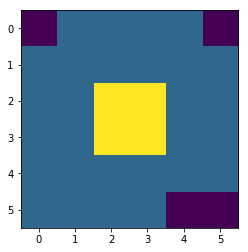

In [22]:
#the data in the extension can be stored like this:
object_1[0].data
#the first extension is empty, it just has the information

#The last extension holds a small image of the source:
object_1[2].header
pylab.imshow(object_1[2].data)

#lets have a look at the second extension
object_1[1]
#This is a table extension

#Here the beginning has a description of columns in the table, including the units
object_1[1].header

(41500, 41700)

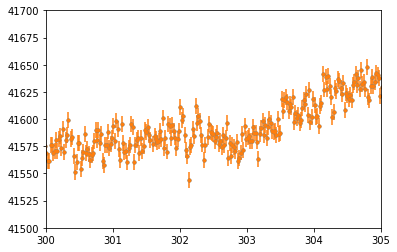

In [27]:
#Lets plot the lightcurve, you can plot the time and flux:
pylab.plot(object_1[1].data['TIME'], object_1[1].data['PDCSAP_FLUX'], ls='None', marker='.')
#This plots the barycentre time and flux in e/s

#Measurements errors are also included, you can plot them as follows
pylab.errorbar(object_1[1].data['TIME'], object_1[1].data['PDCSAP_FLUX'], object_1[1].data['PDCSAP_FLUX_ERR'], ls='None', marker='.')
#We'll need to zoom in to see them:
pylab.xlim(300, 305)
pylab.ylim(41500, 41700)

<ErrorbarContainer object of 3 artists>

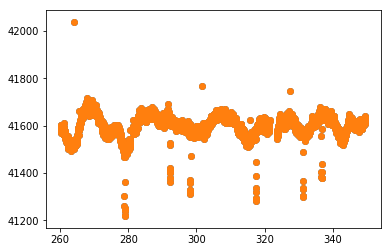

In [92]:
#Lets plot the lightcurve, you can plot the time and flux:
pylab.plot(object_1[1].data['TIME'], object_1[1].data['PDCSAP_FLUX'], ls='None', marker='o')
#This plots the barycentre time and flux in e/s

#Measurements errors are also included, you can plot them as follows
pylab.errorbar(object_1[1].data['TIME'], object_1[1].data['PDCSAP_FLUX'], object_1[1].data['PDCSAP_FLUX_ERR'], ls='None', marker='o')
#We'll need to zoom in to see them:

/anaconda/envs/py35/lib/python3.5/site-packages/scipy/signal/_savitzky_golay.py:187: RankWarning: Polyfit may be poorly conditioned
  xx_edge, polyorder)
/anaconda/envs/py35/lib/python3.5/site-packages/scipy/signal/_savitzky_golay.py:187: RankWarning: Polyfit may be poorly conditioned
  xx_edge, polyorder)


(41200, 42100)

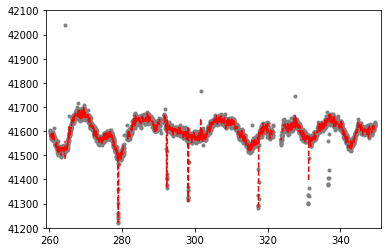

In [106]:
#Savitsky_Golay filter, fitting a polynomial to the data
#initialising variables for interpolation

t = object_1[1].data['TIME'] #time column
f = object_1[1].data['PDCSAP_FLUX'] #point source flux data
e = object_1[1].data['PDCSAP_FLUX_ERR'] #point source flux error

interp_savgol = savgol_filter(f, window_length =13, polyorder=6)

#windowlength is the length of the window over which the polynomial will be fit
#polyorder is the order of the polynimial to be fit

pylab.plot(TIME, FLUX, ls='None', marker='.', c='grey', label='Data')
pylab.plot(TIME, interp_savgol, ls='--', c='r', label='Savitzky Golay w=11,o=1')
pylab.xlim(259, 351)
pylab.ylim(41200, 42100)

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


(41200, 42100)

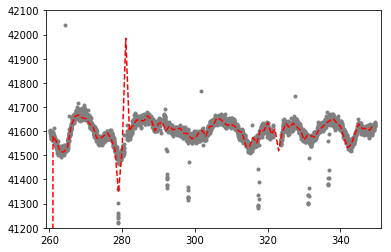

In [113]:
tnew = np.arange(260, 350, 1)
#Nan Inf Mask
mask = ~np.isnan(object_1[1].data['PDCSAP_FLUX']) & ~np.isinf(object_1[1].data['PDCSAP_FLUX'])

newfl = interpolate.spline(t[mask], f[mask], tnew)
pylab.plot(t, f, ls='None', marker='.', c='grey', label='Data')
pylab.plot(tnew, newfl, ls='--', c='r', label='Spline')
pylab.xlim(259, 351)
pylab.ylim(41200, 42100)


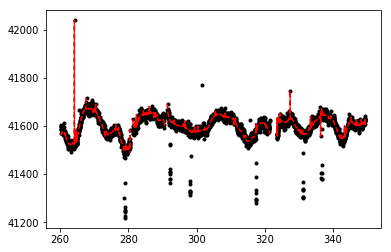

In [111]:
#kernel_size is the size of the window over which the median is calculated 

testfil = medfilt(f, kernel_size=81) 

pylab.plot(t, f, c='k', ls='None', marker='.', label='Data')
pylab.plot(t, testfil, ls='--', c='r', label='Median Filter')

In [ ]:
##FITTING MODELS

#First, define a function, the x value needs to be the first parameter to the function
#the function needs to return f(x)
def func(x, a, b, c):
    return a * numpy.exp(-b * x) + c
### Data plot
pylab.plot(t, f, 'b-', label='data')
##Now fit the data. 
popt, pcov = curve_fit(func, t, f, sigma=e)